In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
ask = pd.read_csv('data/EURUSD_Candlestick_4_Hour_ASK_01.10.2019-31.10.2019.csv')
bid = pd.read_csv('data/EURUSD_Candlestick_4_Hour_BID_01.10.2019-31.10.2019.csv')
ask['Gmt time'] = pd.to_datetime(ask['Gmt time'])
ask = ask.set_index(ask['Gmt time'])
bid['Gmt time'] = pd.to_datetime(bid['Gmt time'])
bid = bid.set_index(bid['Gmt time'])
# ask = ask.set_index("Gmt time")
# bid = bid.set_index("Gmt time")
oa = ask['Open']
ob = bid['Open']

In [132]:
class State:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.MONEY = 10000
        self.POINTS = 0
        self.WINDOW = 12
#         self.WINDOW = 6
        
        self.transaction = []  # (long/short, opening price, points, total price, self.MONEY, self.POINTS)
        self.now = 0
        self.opened = False  # whether agent takes position
        self.open_state = 0  # 1: ask, 0: none, -1: bid
        self.actions = [-1, 0, 1]
        
        
    
    def show(self):
        print(self.MONEY, self.POINTS, self.get_datetime())
        print(self.transaction)
        
    def get_datetime(self, then=-1):
        if then == -1:
            then = self.now
        return ask['Gmt time'][then]
        
    def get_past_n_date(self, n):
        if n-1 > self.now:
            return [self.get_datetime(k) for k in range(self.now+1)]
        else:
            return [self.get_datetime(k) for k in range(self.now-n+1, self.now+1)]
            
    def get_past_n_price(self, n):
        return [round(i, 7) for i in ask["Open"][self.get_past_n_date(n)].tolist()]
        
    def long(self, datetime, points=1000, leverage=10):
        assert datetime in ask['Gmt time']
        
        # change opening state
        self.opened = True
        self.open_state = 1
        self.actions = [-1, 0]
        
        # calculate total price
        current_ask = round(ask['Open'][datetime], 7)
#         print("datetime: {}, current_bid: {}".format(datetime, current_ask))
        price = round(current_ask * points / leverage, 7)

        self.POINTS = round(self.POINTS + points, 7)
        self.MONEY = round(self.MONEY - price, 7)
        self.transaction.append((1, current_ask, points, price, self.MONEY, self.POINTS))

#         print("買入 {} 單位 EURUSD，費用 {} 美元（槓桿X{}）".format(points, price, leverage))
#         print("目前可用 {} 美元、擁有 {} 單位 EURUSD，總資產 {} 美元，".format(self.MONEY, self.POINTS, 10000))
        
        reward = -price
        observation = (self.get_past_n_price(self.WINDOW))
        
        return observation, reward
    
    def short(self, datetime, points=1000, leverage=10):
        assert datetime in ask['Gmt time']
        
        # change opening state
        self.opened = True
        self.open_state = -1
        self.actions = [0, 1]
        
        # calculate total price
        current_bid = round(bid['Open'][datetime], 7)
#         print("datetime: {}, current_bid: {}".format(datetime, current_bid))
        price = round(current_bid * points / leverage, 7)

        self.POINTS = round(self.POINTS + points, 7)
        self.MONEY = round(self.MONEY - price, 7)
        self.transaction.append((-1, current_bid, points, price, self.MONEY, self.POINTS))

#         print("賣出 {} 單位 EURUSD，費用 {} 美元（槓桿X{}）".format(points, price, leverage))
#         print("目前可用 {} 美元、擁有 {} 單位 EURUSD，總資產 {} 美元，".format(self.MONEY, self.POINTS, 10000))
        
        reward = -price
        observation = (self.get_past_n_price(self.WINDOW))
        
        return observation, reward
    
    def ___cal_reward(self):
        reward_list = []
        datetime = self.get_datetime()
        current_bid = round(bid["Open"][datetime], 7)
        for i in range(self.now):
            if self.transaction[i][0] == 1:  # ask
                print(self.transaction[i][1:3])
                opening_price, opening_points = self.transaction[i][1:3]
                profit = round(current_bid - opening_price, 7)
                reward_list.append(round(profit * opening_points, 7))
            elif self.transaction[i][0] == -1:  # bid
                pass
            else:
                raise ValueError("self.transaction[i][0] is not 1 nor -1.")
                
        return reward_list
    
    def take_position(self, action, datetime, points, leverage):
        if action == 1:
            observation, reward = self.long(datetime, points, leverage)
        elif action == -1:
            observation, reward = self.short(datetime, points, leverage)
        else:
            raise ValueError("action should be 1, 0, or -1.")
            
        return observation, reward
    
    def close_position(self, action, datetime):
        observation = ()
        
        opening_askbid = self.transaction[0][1]
        points = self.transaction[0][2]
        total_price = self.transaction[0][3]
        
        # ask or bid
        if action == 1:
            current_askbid = round(ask["Open"][datetime], 7)
        elif action == -1:
            current_askbid = round(bid["Open"][datetime], 7)
            
        profit = round((current_askbid - opening_askbid)*points, 7)
        get_money = round(total_price+profit, 7)
        reward = get_money
#         print(datetime, get_money)
        
        
        self.MONEY = round(self.MONEY+get_money, 7)
        self.POINTS = round(self.POINTS-points, 7)
        
        self.actions = [-1, 0, 1]  #
        self.opened = False  #
        self.open_state = 0  # to func?
        
        observation = (self.get_past_n_price(self.WINDOW))

        return observation, reward
        

    def take_action(self, action, points=1000, leverage=10):
        assert action in [-1, 0, 1]
        
        observation = ()
        reward = 0
        done = False
        info = {}
        
        # ensure not to make multiple positions
        if self.open_state * action == 1:  # it means 1*1 or -1*-1
#             print("Only allow one position each time.")
            print("O", end=" ")
            action = 0
            
        # whether done
        if self.now > ask.shape[0] or self.MONEY < 0:
            done = True
            return observation, reward, done, info
            
        # whether to take any action
        if action == 0:
            observation = (self.get_past_n_price(self.WINDOW))
            reward = 0
        else:        
            # whether opened
            datetime = self.get_datetime()
            if not self.opened:
                observation, reward = self.take_position(action, datetime, points, leverage)
            elif self.opened and action != 0:
                observation, reward = self.close_position(action, datetime)

            
        # calculate reward
#         reward_list = self.cal_reward()
#         reward = round(sum(reward_list), 7)
#         print(reward_list, reward)
        
        # 4 hours later
        self.now += 1
            
        return observation, reward, done, info
            

inv = State()

In [4]:
action = np.random.choice(inv.actions)
print(action)
inv.take_action(action, 1000)

-1
datetime: 2019-01-10 00:00:00, current_bid: 1.08992
賣出 1000 單位 EURUSD，費用 108.992 美元（槓桿X10）
目前可用 9891.008 美元、擁有 1000 單位 EURUSD，總資產 10000 美元，


([1.08996], -108.992, False, {})

In [136]:
def epsilon_greedy(state, q_table, action_space, epsilon):
    if np.random.random_sample() < epsilon or len(state)<12:
#         return action_space.sample() # random choose
        return np.random.choice(action_space)
    else:
        action = np.argmax(q_table[state])
        return action if action!=2 else -1

In [137]:
def get_state(observation, n_buckets, state_bounds):
    state = [0] * len(observation)
    for i, s in enumerate(observation):
        l, u = state_bounds[i][0], state_bounds[i][1] # upper and lower bounds of the state
#         l, u = 1.0888, 1.11723
        if s <= l: # lower than lower bound
            state[i] = 0
        elif s >= u: # higher than upper bound
            state[i] = n_buckets[i] - 1 # maximum (why -1 ?)
        else: # in the range
            state[i] = int(((s-l)/(u-l))*n_buckets[i]) # by rate
#             state[i] = int(((s-l)/(u-l))*4) # by rate
            
    return tuple(state)

In [142]:
# Q table
# number of bucket of each feature in the env
n_buckets = (5, )*inv.WINDOW

# #of action
n_actions = len(inv.actions)

# range of state
state_bounds = [[min(ask['Open']), max(ask['Open'])] for i in range(inv.WINDOW)]

# Q table
q_table = np.zeros(n_buckets + (n_actions,))

# 
get_epsilon = lambda i: max(0.01, min(1, 1.0-math.log10((i+1)/25))) # decreasing
get_lr = lambda i: max(0.01, min(0.5, 1.0-math.log10((i+1)/25))) # decreasing
gamma = 0.99

In [144]:
rl = []
for i_episode in range(200):
    print(i_episode, end=" ")
    epsilon = get_epsilon(i_episode)
    lr = get_lr(i_episode)
    
    inv.reset()
    observation = o
    rewards = 0
    state = get_state(observation, n_buckets, state_bounds)
    for i in range(100):
#         action = np.random.choice(inv.actions)
        action = epsilon_greedy(state, q_table, inv.actions, epsilon)
        aa.append(action)
        observation, r, d, i = inv.take_action(action, 1000)
        rewards += r
        
        next_state = get_state(observation, n_buckets, state_bounds)
        
        # update Q table
        q_next_max = np.amax(q_table[next_state]) # 進入下一個 state 後，預期得到最大總 reward
        q_table[state+(action,)] += lr * (r + gamma * q_next_max - q_table[state+(action,)])
        
        # go to next state
        state = next_state
        
    rl.append(rewards)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 O O 27 O 28 29 30 O O 31 O O 32 33 O O O O 34 O 35 O 36 O O 37 O O 38 O O 39 40 O O O O O 41 O O O 42 O O O O O 43 O O O O O O O 44 O O O O 45 O O O O O 46 O O 47 O O O O O 48 O O O 49 O O O O O 50 O O O O 51 O O O O O O O O 52 O O O O O O 53 O O O O O O 54 O O O O O O O O O O O 55 O O O O O O 56 O O O O 57 O O O O O 58 O O O O O O O O O 59 O O O O O O 60 O O O O O O O O O 61 O O O O O O O 62 O O O O O O O O O O O O O O 63 O O O O O O O O 64 O O O O O O O 65 O O O O O O O O O O O 66 O O O O O O O 67 O O O O O O O 68 O 69 O O O O O O 70 O O O O O O 71 O O O O O O O O O O O O O 72 O O O O O O O O 73 O O O O O O O O O 74 O O O O O O O O O 75 O O O O O O 76 O O O O O O O O O 77 O O O O O 78 O O O O O 79 O O O O O 80 O O O O O O O O 81 O O O O O O O O 82 O O O O O O O O O O O 83 O O O O O O O O O O O O O O O O O 84 O O O O O O O O O O O O O 85 O O O O O O O O 86 O O O O O O 87 O O O O O O O O O O O O O 88 O O O O O 89 O 

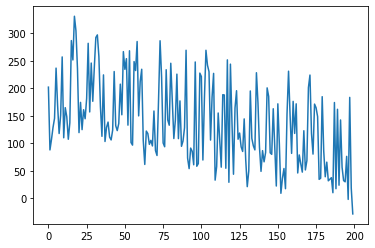

In [145]:
plt.plot(rl)